# Modeling
1. Sensitivity analysis for GPR modeling.
1) Varying Smoothing Window: We fixed the 7-day difference on the logarithmic scale and varied the 30-day smoothing window to 1, 3, 5, 10, 20, 30, and 50 days, using the same GPR method to model the data.

In [53]:
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns

# Load the dataset
data_path = 'UK_2022_2023.csv'  # Replace with your local path
data_df = pd.read_csv(data_path)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%m/%d/%Y')

# Define window sizes and initialize storage for results
window_sizes = [1, 3, 5, 10, 20, 30, 50]
gp_models_results = []

# Loop through different window sizes
for window_size in window_sizes:
    # Apply moving average and compute Delta_7
    temp_df = data_df.copy()  # Create a temporary copy for this window size
    temp_df['Cases_MA'] = temp_df['Cases'].rolling(window=window_size).mean()
    temp_df['Delta_7'] = np.log10(temp_df['Cases_MA']) - np.log10(temp_df['Cases_MA'].shift(7))
    temp_df = temp_df.dropna(subset=['Delta_7'])

    # Prepare data
    X = np.arange(len(temp_df)).reshape(-1, 1).astype(np.float64)
    Y = temp_df['Delta_7'].values.reshape(-1, 1).astype(np.float64)

    # Define and train GPR model
    kernel = gpflow.kernels.SquaredExponential()
    model = gpflow.models.GPR(data=(X, Y), kernel=kernel, likelihood=gpflow.likelihoods.Gaussian(variance_lower_bound=0.002))
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)

    # Make predictions
    mean, var = model.predict_f(X)
    mse = mean_squared_error(Y, mean)
    lower_bound = mean.numpy().flatten() - 1.96 * np.sqrt(var.numpy().flatten())
    upper_bound = mean.numpy().flatten() + 1.96 * np.sqrt(var.numpy().flatten())
    within_ci = np.sum((Y.flatten() >= lower_bound) & (Y.flatten() <= upper_bound)) / len(Y) * 100

    # Store results
    gp_models_results.append((window_size, temp_df['Date'], temp_df['Delta_7'], mean.numpy().flatten(), var.numpy().flatten(), mse, within_ci))



<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
C:\Users\bshe6\AppData\Local\Temp\1\ipykernel_25172\1595520136.py:29: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta_7$ (Log Differences)', fontsize=30)


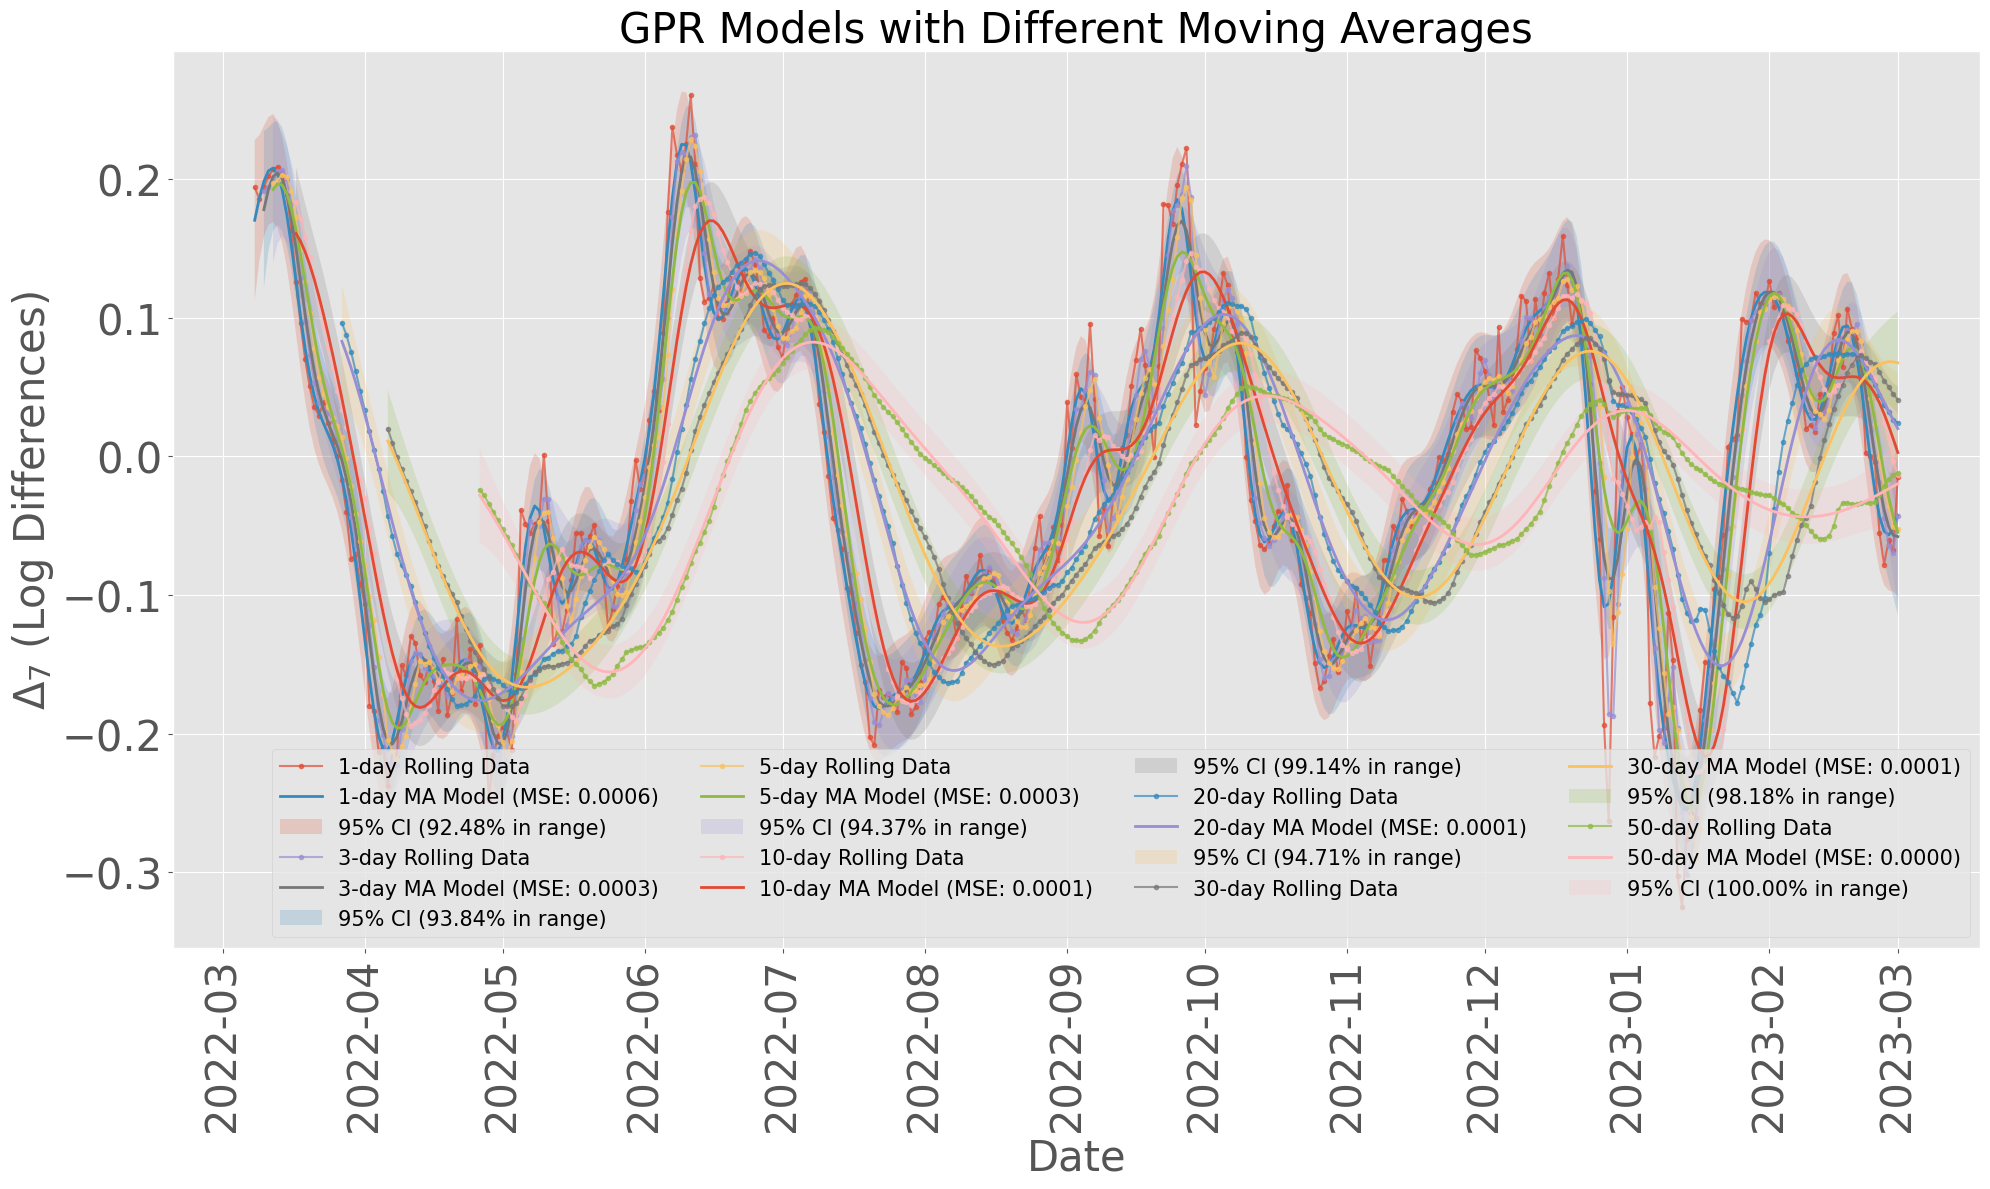

In [54]:
# Plot all models on the same figure
plt.style.use('ggplot')
plt.figure(figsize=(20, 12))
start_date = data_df['Date'].min()
end_date = data_df['Date'].max()

for window_size, dates, actual_vals, mean_vals, var_vals, mse, within_ci in gp_models_results:
    aligned_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    aligned_actual_vals = np.full(len(aligned_dates), np.nan)
    aligned_mean_vals = np.full(len(aligned_dates), np.nan)
    aligned_var_vals = np.full(len(aligned_dates), np.nan)

    aligned_actual_vals[np.isin(aligned_dates, dates)] = actual_vals
    aligned_mean_vals[np.isin(aligned_dates, dates)] = mean_vals
    aligned_var_vals[np.isin(aligned_dates, dates)] = var_vals

    plt.plot(aligned_dates, aligned_actual_vals, 'o-', label=f'{window_size}-day Rolling Data', markersize=3, alpha=0.7)
    plt.plot(aligned_dates, aligned_mean_vals, label=f'{window_size}-day MA Model (MSE: {mse:.4f})', linewidth=2)
    plt.fill_between(aligned_dates, 
                     aligned_mean_vals - 1.96 * np.sqrt(aligned_var_vals), 
                     aligned_mean_vals + 1.96 * np.sqrt(aligned_var_vals), 
                     alpha=0.2, label=f'95% CI ({within_ci:.2f}% in range)')

# Formatting
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.title('GPR Models with Different Moving Averages', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.ylabel('$\Delta_7$ (Log Differences)', fontsize=30)
plt.legend(fontsize=15, loc='lower right', ncol= 4)
plt.grid(True)
plt.xticks(fontsize=30, rotation=90)
plt.yticks(fontsize=30)
plt.tight_layout()




# Save and show the plot
plt.savefig('GPR_Models_Moving_Average_Comparison.png', dpi=60, bbox_inches='tight')
plt.show()


# Modeling
1. Sensitivity analysis for GPR modeling.
2) Varying Log Differences: We fixed the 30-day smoothing window and varied the 7-day difference to 3, 7, 14, 21, and 28 days, comparing the modeling results using the same GPR approach.

In [55]:
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns

# Load the dataset
data_path = 'UK_2022_2023.csv'  # Replace with your local path
data_df = pd.read_csv(data_path)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%m/%d/%Y')

# Fixed window size
window_size = 30
lags = [3, 7, 14, 21, 28]  # Different lag values for Delta computation

# Initialize storage for results
gp_models_results = []

# Prepare a common date range for alignment
start_date = data_df['Date'].min()
end_date = data_df['Date'].max()
common_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Use seaborn's color palette for distinct colors
colors = sns.color_palette('tab10', len(lags))

# Loop through different lag values
for lag in lags:
    # Apply moving average and compute Delta with the current lag
    temp_df = data_df.copy()  # Create a temporary copy for this lag value
    temp_df['Cases_MA'] = temp_df['Cases'].rolling(window=window_size).mean()
    temp_df['Delta_7'] = np.log10(temp_df['Cases_MA']) - np.log10(temp_df['Cases_MA'].shift(lag))
    temp_df = temp_df.dropna(subset=['Delta_7'])

    # Prepare data
    X = np.arange(len(temp_df)).reshape(-1, 1).astype(np.float64)
    Y = temp_df['Delta_7'].values.reshape(-1, 1).astype(np.float64)

    # Define and train GPR model
    kernel = gpflow.kernels.SquaredExponential()
    model = gpflow.models.GPR(data=(X, Y), kernel=kernel, likelihood=gpflow.likelihoods.Gaussian(variance_lower_bound=0.002))
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)

    # Make predictions
    mean, var = model.predict_f(X)
    mse = mean_squared_error(Y, mean)
    lower_bound = mean.numpy().flatten() - 1.96 * np.sqrt(var.numpy().flatten())
    upper_bound = mean.numpy().flatten() + 1.96 * np.sqrt(var.numpy().flatten())
    within_ci = np.sum((Y.flatten() >= lower_bound) & (Y.flatten() <= upper_bound)) / len(Y) * 100

    # Align predictions with the common date range
    aligned_mean = np.full(len(common_dates), np.nan)
    aligned_actual = np.full(len(common_dates), np.nan)
    aligned_var = np.full(len(common_dates), np.nan)

    valid_dates = temp_df['Date']
    aligned_mean[np.isin(common_dates, valid_dates)] = mean.numpy().flatten()
    aligned_actual[np.isin(common_dates, valid_dates)] = Y.flatten()
    aligned_var[np.isin(common_dates, valid_dates)] = var.numpy().flatten()

    # Store results
    gp_models_results.append((lag, aligned_mean, aligned_var, aligned_actual, mse, within_ci))



<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
C:\Users\bshe6\AppData\Local\Temp\1\ipykernel_25172\2073820453.py:15: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta_{lag}$ (Log Differences)', fontsize=30)


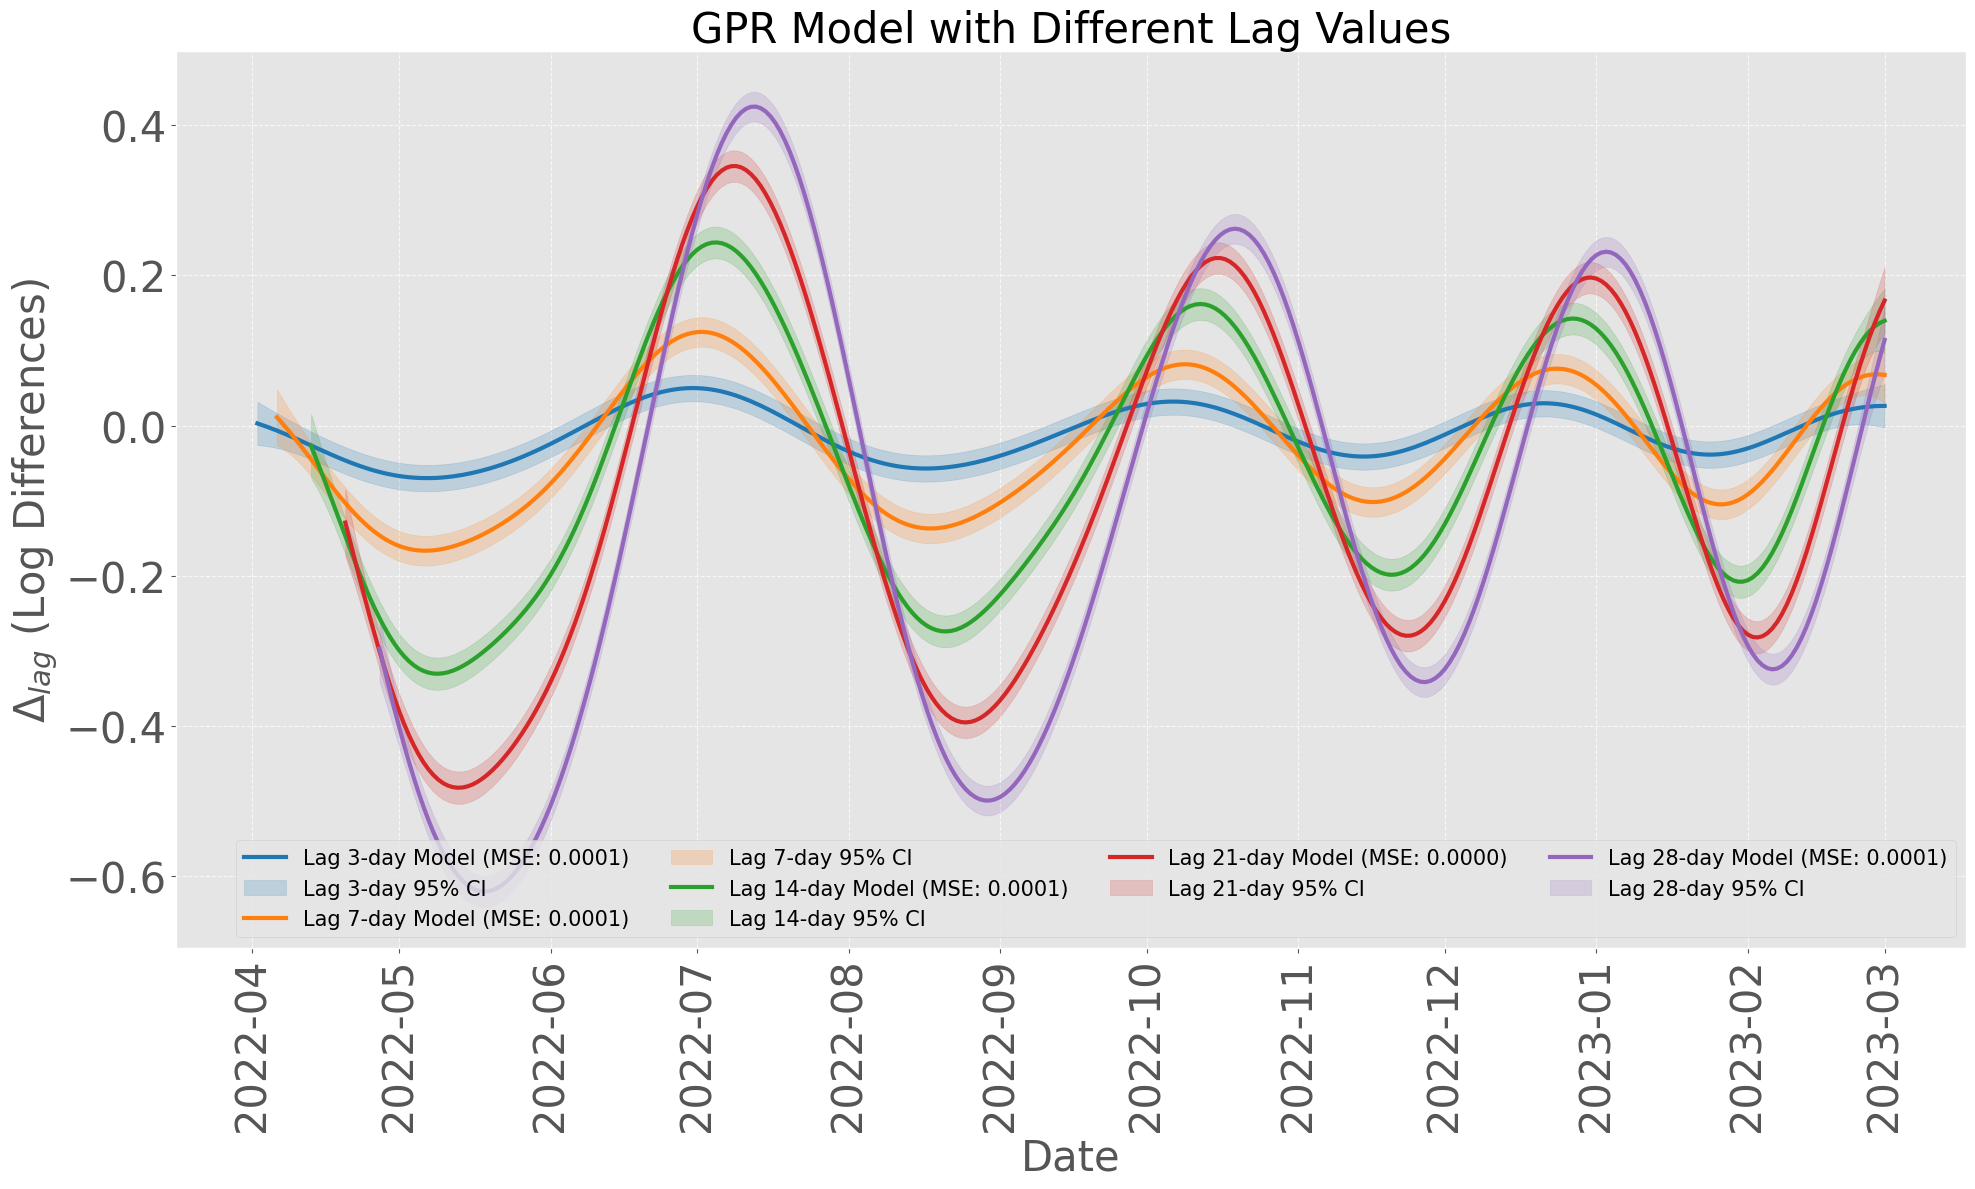

In [56]:
# Plot all models in the same figure
plt.figure(figsize=(20, 12))

for i, (lag, aligned_mean, aligned_var, aligned_actual, mse, within_ci) in enumerate(gp_models_results):
    # Plot the GPR model predictions
    plt.plot(common_dates, aligned_mean, label=f'Lag {lag}-day Model (MSE: {mse:.4f})', linewidth=3, color=colors[i])
    # Plot confidence intervals
    plt.fill_between(common_dates, aligned_mean - 1.96 * np.sqrt(aligned_var), aligned_mean + 1.96 * np.sqrt(aligned_var), 
                     alpha=0.2, color=colors[i], label=f'Lag {lag}-day 95% CI')
# Format the plot
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.title('GPR Model with Different Lag Values', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.ylabel('$\Delta_{lag}$ (Log Differences)', fontsize=30)
plt.xticks(fontsize=30, rotation=90)
plt.yticks(fontsize=30)
plt.legend(fontsize=15, loc='lower right', ncol= 4)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and show the figure
plt.savefig('GPR_Model_Lag_Combined.png', dpi=60, bbox_inches='tight')
plt.show()


# Prediction
2. Sensitivity analysis for GPR prediction
1) Varying Smoothing Window: We fixed the 7-day difference on the logarithmic scale and varied the 30-day smoothing window to 1, 3, 5, 10, 20, 30, and 50 days, using the same GPR method to predict the spread.


In [57]:
import numpy as np
import gpflow
from gpflow.kernels import SquaredExponential
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load the dataset
data_path = 'UK_2022_2023.csv'  # Replace with the correct path
data_df = pd.read_csv(data_path)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%m/%d/%Y')

# Window sizes for moving average
window_sizes = [1, 3, 5, 10, 20, 30, 50]

# Parameters
T = 1
tau = 2.5
delta = 0.05
sigma_squared = 0.003

# Prepare a common date range for alignment
start_date = data_df['Date'].min()
end_date = data_df['Date'].max()
common_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Initialize storage for plotting
results = []

# Loop through each window size
for window_size in window_sizes:
    temp_df = data_df.copy()
    temp_df['Cases_MA'] = temp_df['Cases'].rolling(window=window_size).mean()
    temp_df['Delta_7'] = np.log10(temp_df['Cases_MA']) - np.log10(temp_df['Cases_MA'].shift(7))
    temp_df = temp_df.dropna(subset=['Delta_7'])  # Remove NaN values after moving average
    
    data = temp_df['Delta_7'].values
    dates = temp_df['Date'].values

    # Initialize lists to store results
    all_means = []
    all_variances = []
    mean_indices = []
    within_95_ci_count = 0
    total_predictions = 0

    # Compute gamma
    gamma = 2 * (np.log(T / (2 * tau * delta)) + 1 / delta)

    # Train and predict using an increasing window size with 30 training data points each time
    for start_idx in range(30, len(data) - 20, 20):  # Moving window of size 20
        train_idx = np.arange(start_idx - 30, start_idx)
        test_idx = np.arange(start_idx, start_idx + 20)
        
        X_train = train_idx.reshape(-1, 1).astype(np.float64)
        Y_train = data[train_idx].reshape(-1, 1).astype(np.float64)
        
        X_test = test_idx.reshape(-1, 1).astype(np.float64)
        Y_test = data[test_idx].reshape(-1, 1).astype(np.float64)
        
        # Define the Squared Exponential kernel
        kernel = SquaredExponential()
        
        # Define the GP model
        model_I = gpflow.models.GPR(
            data=(X_train, Y_train),
            kernel=kernel,
            likelihood=gpflow.likelihoods.Gaussian(variance_lower_bound=sigma_squared)
        )
        
        # Set up the optimizer
        opt = gpflow.optimizers.Scipy()
        
        # Train the model
        opt.minimize(model_I.training_loss, model_I.trainable_variables)
        
        # Predict at the test locations
        I_mean, I_var = model_I.predict_f(X_test)
        
        # Store the means and variances for plotting
        all_means.append(I_mean.numpy().flatten())
        all_variances.append(np.sqrt(I_var.numpy().flatten()))
        mean_indices.extend(test_idx - 5)  # Shift predictions back by 5 dates to align
        
        # Compute 95% confidence intervals and count predictions within them
        for i in range(len(test_idx)):
            lower_bound = I_mean.numpy()[i, 0] - 1.96 * np.sqrt(I_var.numpy()[i, 0])
            upper_bound = I_mean.numpy()[i, 0] + 1.96 * np.sqrt(I_var.numpy()[i, 0])
            total_predictions += 1
            if lower_bound <= Y_test[i, 0] <= upper_bound:
                within_95_ci_count += 1

    # Convert lists to arrays
    all_means = np.concatenate(all_means)
    all_variances = np.concatenate(all_variances)
    mean_indices = np.array(mean_indices)

    # Align predictions and actual values with common date range
    aligned_means = np.full(len(common_dates), np.nan)
    aligned_actuals = np.full(len(common_dates), np.nan)
    aligned_variances = np.full(len(common_dates), np.nan)
    
    valid_indices = np.isin(common_dates, dates[mean_indices])
    aligned_means[valid_indices] = all_means
    aligned_variances[valid_indices] = all_variances
    aligned_actuals[valid_indices] = data[mean_indices]

    # Compute MSE and percentage within 95% CI
    mse = mean_squared_error(data[mean_indices], all_means)
    within_95_ci_percentage = (within_95_ci_count / total_predictions) * 100

    # Store results for plotting
    results.append((window_size, aligned_means, aligned_variances, aligned_actuals, mse, within_95_ci_percentage))



<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
C:\Users\bshe6\AppData\Local\Temp\1\ipykernel_25172\1040369846.py:12: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta_7$', fontsize=30)


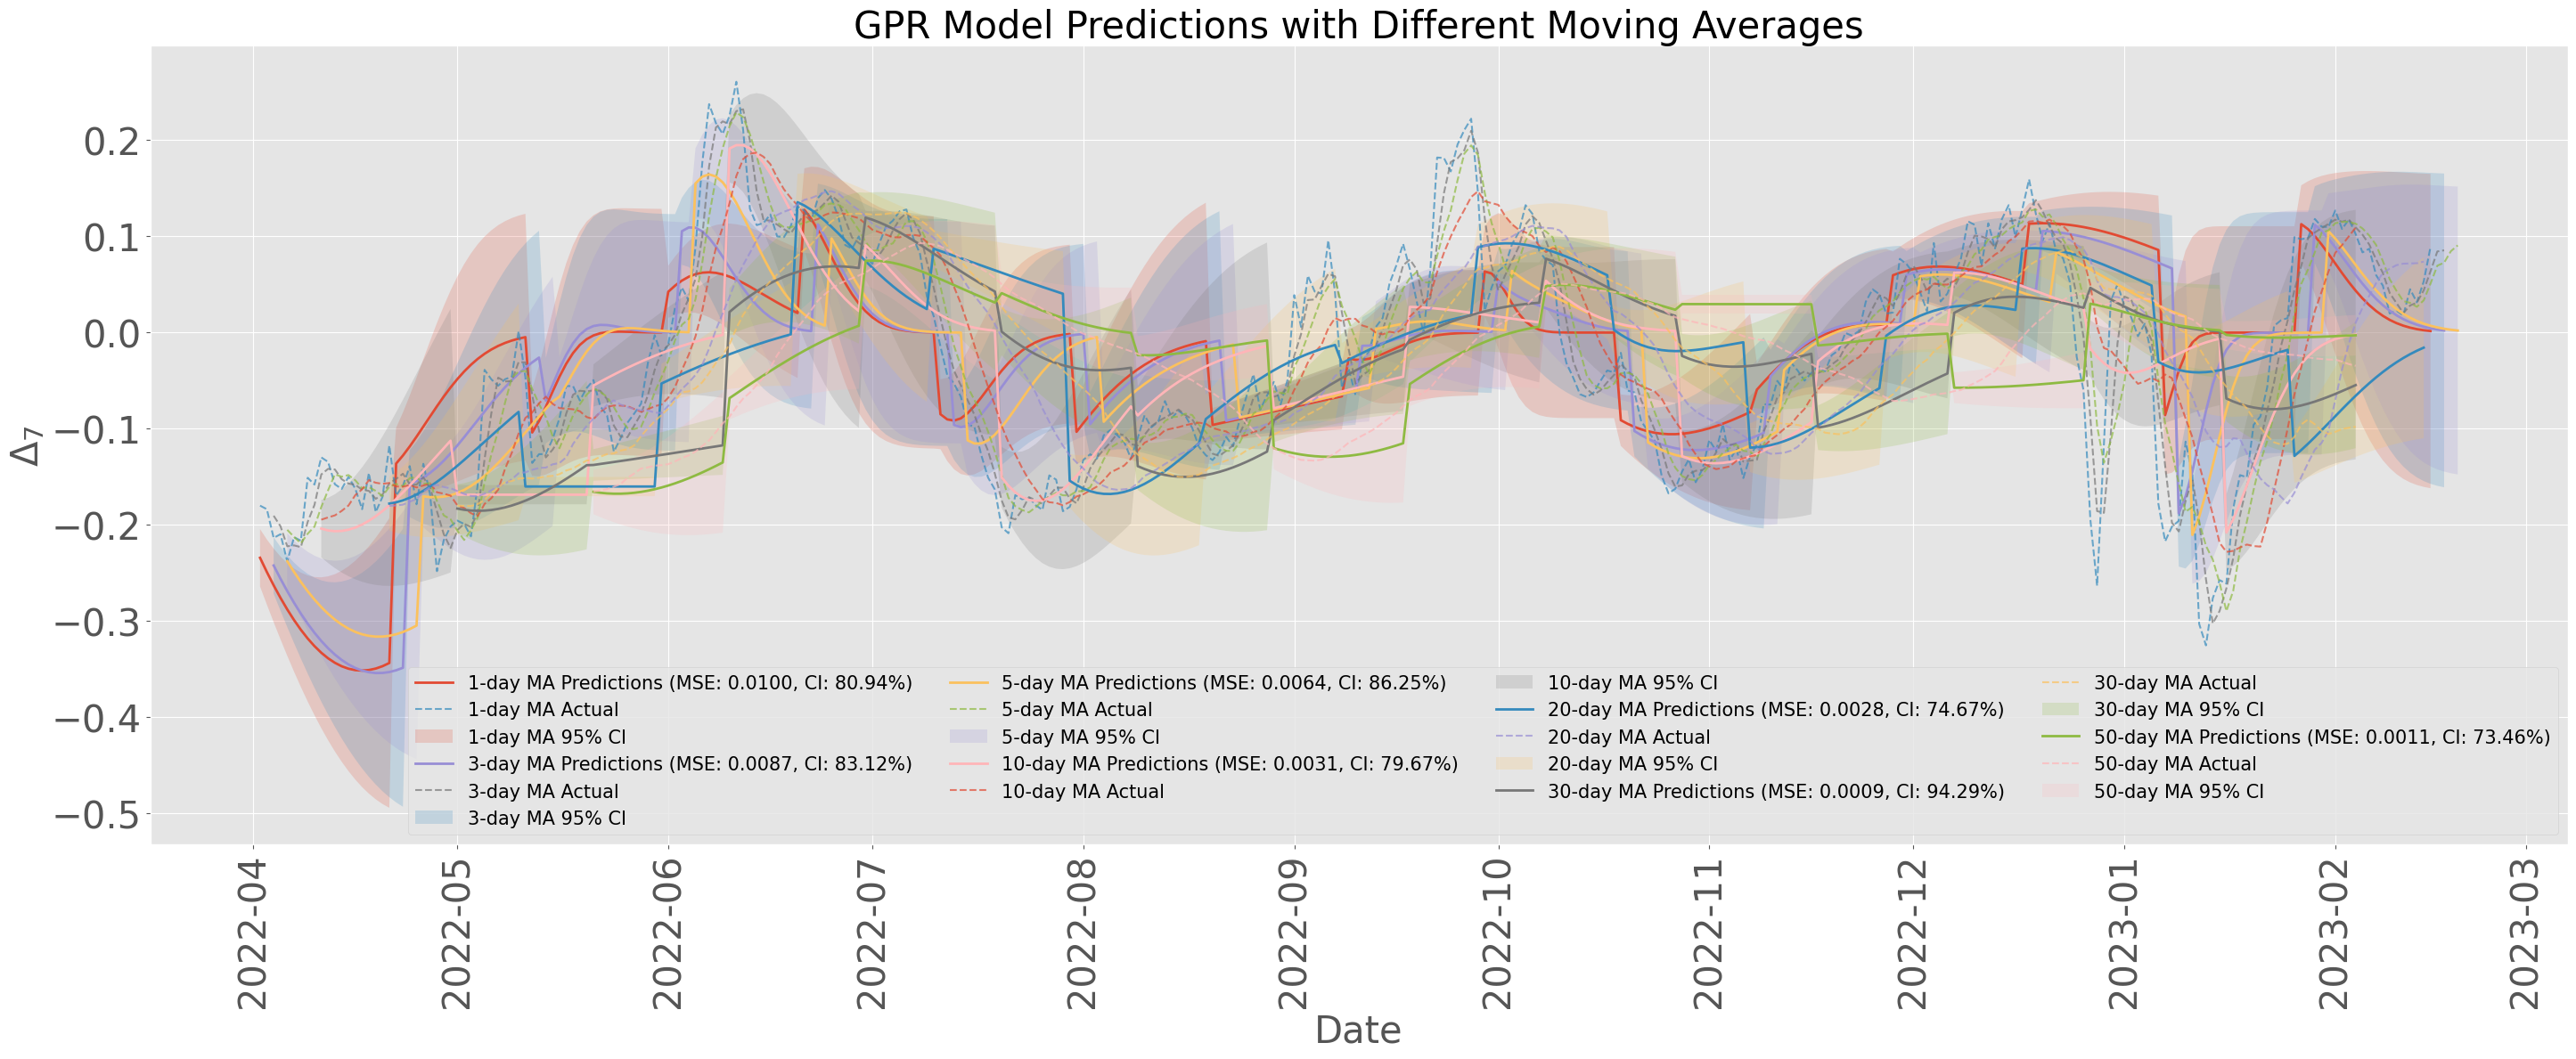

In [58]:
# Plot all results in a single figure
plt.figure(figsize=(30, 12))

for window_size, aligned_means, aligned_variances, aligned_actuals, mse, within_95_ci_percentage in results:
    plt.plot(common_dates, aligned_means, label=f'{window_size}-day MA Predictions (MSE: {mse:.4f}, CI: {within_95_ci_percentage:.2f}%)', linewidth=2)
    plt.plot(common_dates, aligned_actuals, linestyle='--', label=f'{window_size}-day MA Actual', alpha=0.7)
    plt.fill_between(common_dates, aligned_means - aligned_variances, aligned_means + aligned_variances, alpha=0.2, label=f'{window_size}-day MA 95% CI')



plt.xlabel('Date', fontsize=30)
plt.ylabel('$\Delta_7$', fontsize=30)
plt.title('GPR Model Predictions with Different Moving Averages', fontsize=30)
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=15, ncol=4)
plt.grid(True)
plt.tight_layout()

# Save and show the plot
plt.savefig('GPR_Moving_Average_Combined.png', dpi=60, bbox_inches='tight')
plt.show()


# Prediction
2. Sensitivity analysis for GPR prediction
2) Varying Log Differences: We fixed the 30-day smoothing window and varied the 7-day difference to 1, 3, 7, 14, 21, and 28 days, comparing the prediction results using the same GPR prediction approach.

In [59]:
import numpy as np
import gpflow
from gpflow.kernels import SquaredExponential
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load the dataset
data_path = 'UK_2022_2023.csv'  # Replace with the correct path
data_df = pd.read_csv(data_path)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%m/%d/%Y')

# Fixed window size for moving average
window_size = 30

# Different lag values
lags = [1, 3, 7, 14, 21, 28]

# Parameters
T = 1
tau = 2.5
delta = 0.05
sigma_squared = 0.003

# Prepare a common date range for alignment
start_date = data_df['Date'].min()
end_date = data_df['Date'].max()
common_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Initialize storage for plotting
results = []

# Loop through each lag value
for lag in lags:
    temp_df = data_df.copy()
    temp_df['Cases_MA'] = temp_df['Cases'].rolling(window=window_size).mean()
    temp_df['Delta_7'] = np.log10(temp_df['Cases_MA']) - np.log10(temp_df['Cases_MA'].shift(lag))
    temp_df = temp_df.dropna(subset=['Delta_7'])  # Remove NaN values after moving average
    
    data = temp_df['Delta_7'].values
    dates = temp_df['Date'].values

    # Initialize lists to store results
    all_means = []
    all_variances = []
    mean_indices = []
    within_95_ci_count = 0
    total_predictions = 0

    # Compute gamma
    gamma = 2 * (np.log(T / (2 * tau * delta)) + 1 / delta)

    # Train and predict using an increasing window size with 30 training data points each time
    for start_idx in range(30, len(data) - 20, 20):  # Moving window of size 20
        train_idx = np.arange(start_idx - 30, start_idx)
        test_idx = np.arange(start_idx, start_idx + 20)
        
        X_train = train_idx.reshape(-1, 1).astype(np.float64)
        Y_train = data[train_idx].reshape(-1, 1).astype(np.float64)
        
        X_test = test_idx.reshape(-1, 1).astype(np.float64)
        Y_test = data[test_idx].reshape(-1, 1).astype(np.float64)
        
        # Define the Squared Exponential kernel
        kernel = SquaredExponential()
        
        # Define the GP model
        model_I = gpflow.models.GPR(
            data=(X_train, Y_train),
            kernel=kernel,
            likelihood=gpflow.likelihoods.Gaussian(variance_lower_bound=sigma_squared)
        )
        
        # Set up the optimizer
        opt = gpflow.optimizers.Scipy()
        
        # Train the model
        opt.minimize(model_I.training_loss, model_I.trainable_variables)
        
        # Predict at the test locations
        I_mean, I_var = model_I.predict_f(X_test)
        
        # Store the means and variances for plotting
        all_means.append(I_mean.numpy().flatten())
        all_variances.append(np.sqrt(I_var.numpy().flatten()))
        mean_indices.extend(test_idx - 5)  # Shift predictions back by 5 dates to align
        
        # Compute 95% confidence intervals and count predictions within them
        for i in range(len(test_idx)):
            lower_bound = I_mean.numpy()[i, 0] - 1.96 * np.sqrt(I_var.numpy()[i, 0])
            upper_bound = I_mean.numpy()[i, 0] + 1.96 * np.sqrt(I_var.numpy()[i, 0])
            total_predictions += 1
            if lower_bound <= Y_test[i, 0] <= upper_bound:
                within_95_ci_count += 1

    # Convert lists to arrays
    all_means = np.concatenate(all_means)
    all_variances = np.concatenate(all_variances)
    mean_indices = np.array(mean_indices)

    # Align predictions and actual values with common date range
    aligned_means = np.full(len(common_dates), np.nan)
    aligned_actuals = np.full(len(common_dates), np.nan)
    aligned_variances = np.full(len(common_dates), np.nan)
    
    valid_indices = np.isin(common_dates, dates[mean_indices])
    aligned_means[valid_indices] = all_means
    aligned_variances[valid_indices] = all_variances
    aligned_actuals[valid_indices] = data[mean_indices]

    # Compute MSE and percentage within 95% CI
    mse = mean_squared_error(data[mean_indices], all_means)
    within_95_ci_percentage = (within_95_ci_count / total_predictions) * 100

    # Store results for plotting
    results.append((lag, aligned_means, aligned_variances, aligned_actuals, mse, within_95_ci_percentage))



<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
C:\Users\bshe6\AppData\Local\Temp\1\ipykernel_25172\2517537453.py:9: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta_7$', fontsize=30)


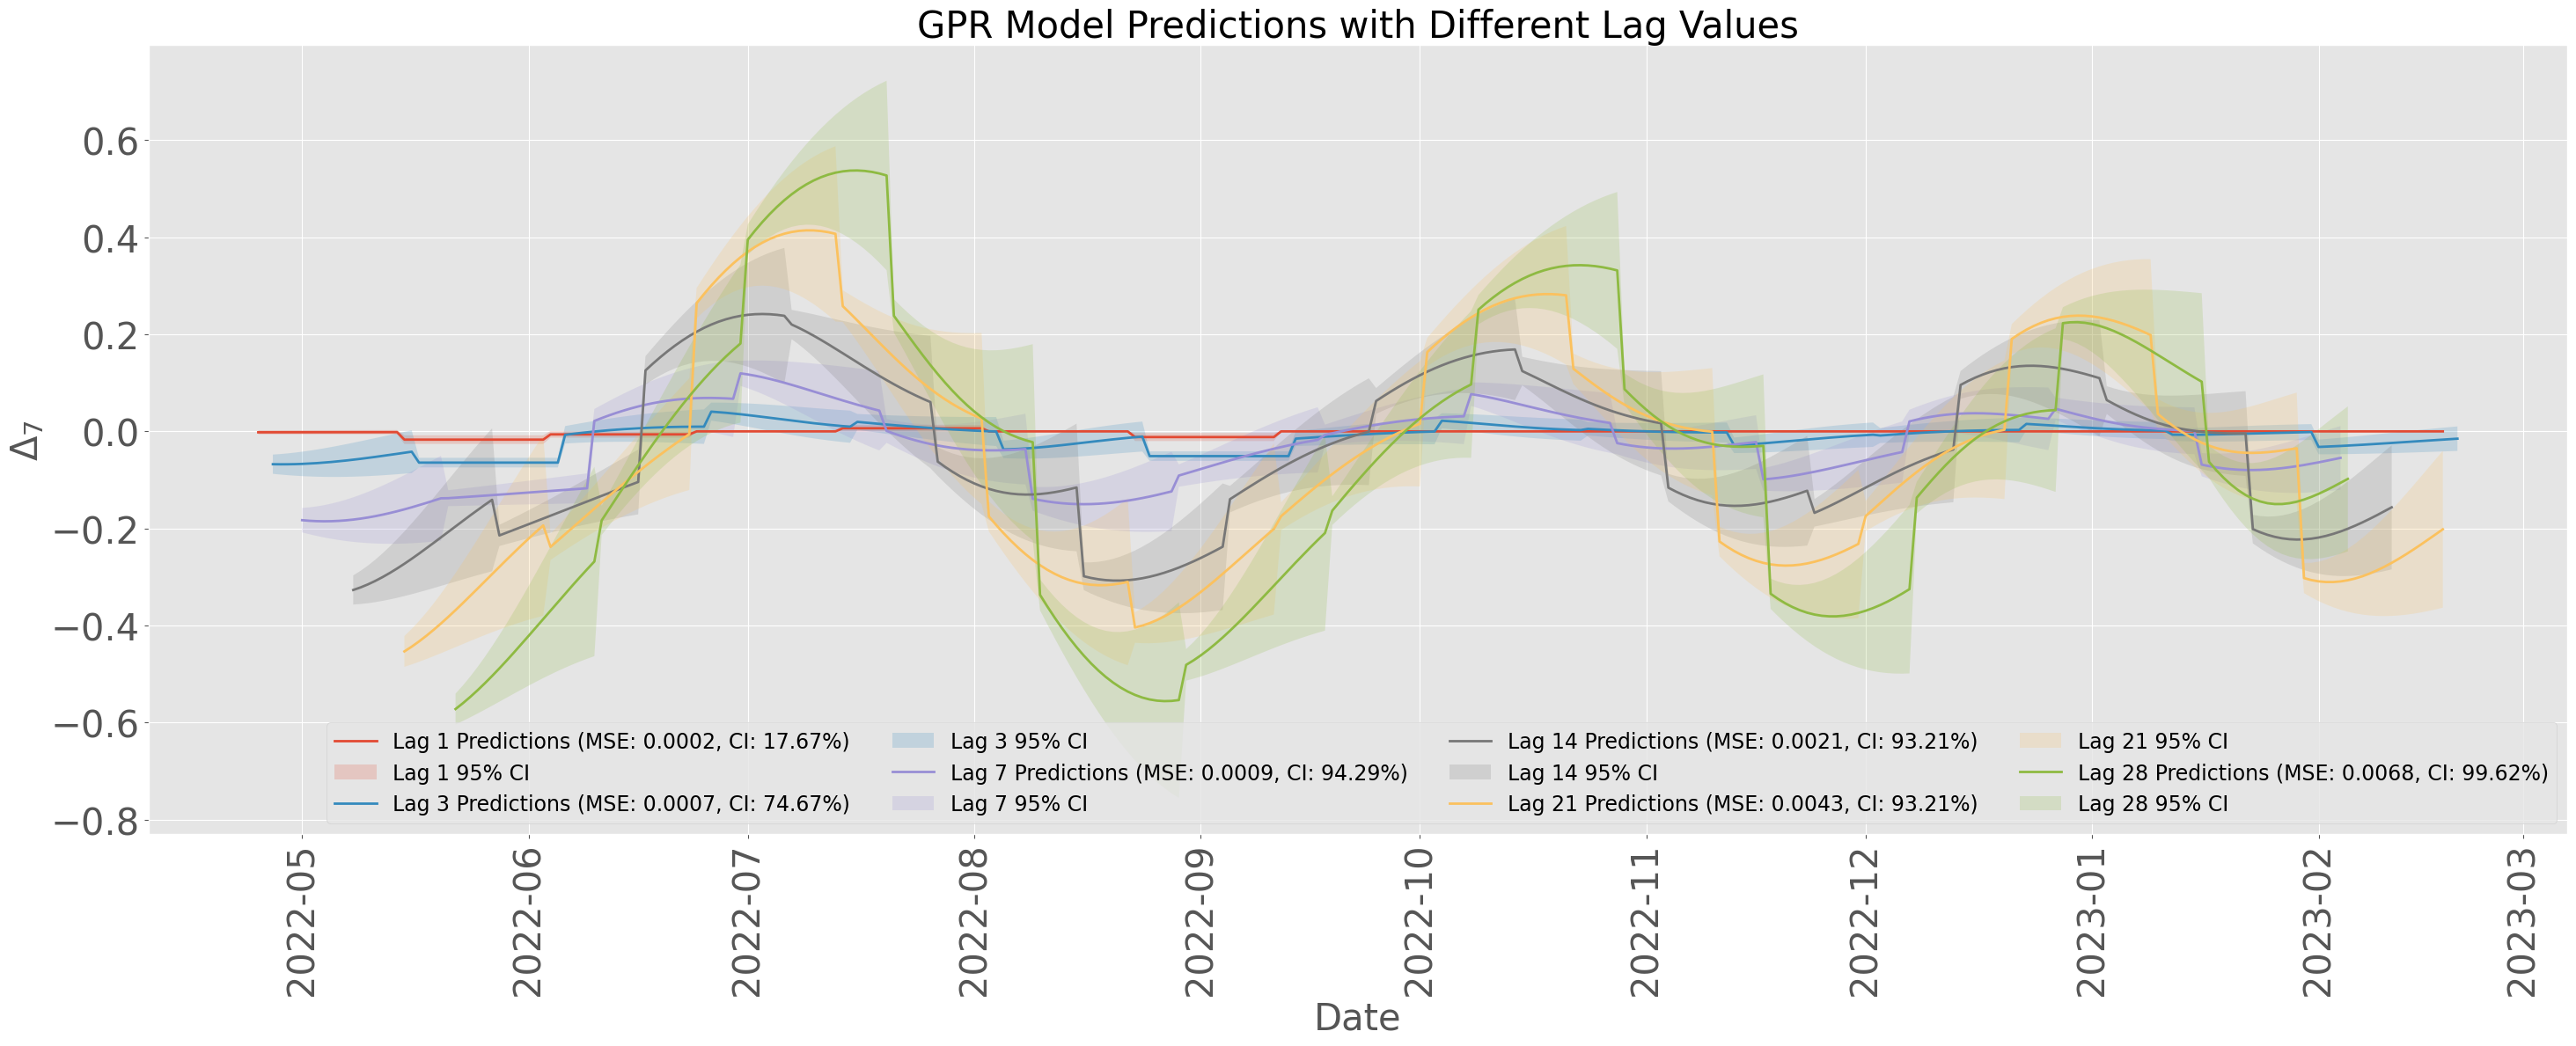

In [60]:
# Plot all results in a single figure
plt.figure(figsize=(30, 12))

for lag, aligned_means, aligned_variances, aligned_actuals, mse, within_95_ci_percentage in results:
    plt.plot(common_dates, aligned_means, label=f'Lag {lag} Predictions (MSE: {mse:.4f}, CI: {within_95_ci_percentage:.2f}%)', linewidth=2)
    plt.fill_between(common_dates, aligned_means - aligned_variances, aligned_means + aligned_variances, alpha=0.2, label=f'Lag {lag} 95% CI')

plt.xlabel('Date', fontsize=30)
plt.ylabel('$\Delta_7$', fontsize=30)
plt.title('GPR Model Predictions with Different Lag Values', fontsize=30)
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=17, loc='lower right', ncol= 4)
plt.grid(True)
plt.tight_layout()

# Save and show the plot
plt.savefig('GPR_Lag_Comparison_Combined.png', dpi=60, bbox_inches='tight')
plt.show()
